In [2]:
%%file gauss_quad.f


*function used by gauss-legendre. Private function
      REAL*8 FUNCTION gammln(xx)
      REAL*8 xx
      INTEGER j
      REAL*8 ser,stp,tmp,x,y,cof(6)
      SAVE cof,stp
      DATA cof,stp/76.18009172947146d0,-86.50532032941677d0,
     *24.01409824083091d0,-1.231739572450155d0,.1208650973866179d-2,
     *-.5395239384953d-5,2.5066282746310005d0/
      x=xx
      y=x
      tmp=x+5.5d0
      tmp=(x+0.5d0)*log(tmp)-tmp
      ser=1.000000000190015d0
      DO j=1,6
        y=y+1.d0
        ser=ser+cof(j)/y
      END DO
      gammln=tmp+LOG(stp*ser/x)
      RETURN
      END
* gauss legendre quadrature that solves the problem
*   \int_{x1}^{x2} f(x)dx = \sum_{j=1}^n w_j f(x_j)
* This routine accepts x1,x2 and n and returns the vectors x and w.
* the function is not required to be passed to it.
      SUBROUTINE gauleg(x1,x2,x,w,n)
c
cf2py intent(out) :: x
cf2py intent(out) :: w
cf2py integer :: n
cf2py real*8 :: x1
cf2py real*8 :: x2
cf2py real*8 :: x
cf2py real*8 :: w
c
      INTEGER n
      REAL*8 x1,x2,x(n),w(n)
      REAL*8 EPS
      PARAMETER (EPS=3.D-14)
      PARAMETER (PIM4=.7511255444649425D0)
      PARAMETER (MAXIT=10)
      INTEGER i,j,m
      REAL*8 p1,p2,p3,pp,xl,xm,z,z1
      m=(n+1)/2
      xm=0.5d0*(x2+x1)
      xl=0.5d0*(x2-x1)
      DO i=1,m
         z=COS(3.141592654d0*(i-.25d0)/(n+.5d0))
         DO WHILE(.TRUE.)
            p1=1.d0
            p2=0.d0
            DO j=1,n
               p3=p2
               p2=p1
               p1=((2.d0*j-1.d0)*z*p2-(j-1.d0)*p3)/j
            END DO
            pp=n*(z*p1-p2)/(z*z-1.d0)
            z1=z
            z=z1-p1/pp
            IF(ABS(z-z1).LE.EPS)EXIT
         END DO
         x(i)=xm-xl*z
         x(n+1-i)=xm+xl*z
         w(i)=2.d0*xl/((1.d0-z*z)*pp*pp)
         w(n+1-i)=w(i)
      END DO
      RETURN
      END
* gauss-laguare quadrature that solves the problem
      SUBROUTINE gaulag(x,w,n,alf)
c
cf2py intent(out) :: x
cf2py intent(out) :: w
cf2py integer :: n
cf2py real*8 :: alf
cf2py real*8 :: x
cf2py real*8 :: w
c
      INTEGER n,MAXIT
      REAL*8 alf,w(n),x(n)
      REAL*8 EPS
      PARAMETER (EPS=3.D-14)
      PARAMETER (PIM4=.7511255444649425D0)
      PARAMETER (MAXIT=10)
C     USES gammln
      INTEGER i,its,j
      REAL*8 ai,gammln
      REAL*8 p1,p2,p3,pp,z,z1
      DO i=1,n
         IF(i.EQ.1)THEN
            z=(1.d0+alf)*(3.d0+.92d0*alf)/(1.d0+2.4d0*n+1.8d0*alf)
         ELSE IF(i.EQ.2)THEN
            z=z+(15.d0+6.25d0*alf)/(1.d0+.9d0*alf+2.5d0*n)
         ELSE
            ai=i-2
            z=z+((1.d0+2.55d0*ai)/(1.9d0*ai)+1.26d0*ai*alf/
     *           (1.+3.5d0*ai))*(z-x(i-2))/(1.d0+.3d0*alf)
         ENDIF
         DO its=1,MAXIT
            p1=1.d0
            p2=0.d0
            DO j=1,n
               p3=p2
               p2=p1
               p1=((2*j-1+alf-z)*p2-(j-1+alf)*p3)/j
            END DO
            pp=(n*p1-(n+alf)*p2)/z
            z1=z
            z=z1-p1/pp
            IF(ABS(z-z1).LE.EPS)THEN
               EXIT
            ENDIF
         END DO
         x(i)=z
         w(i)=-exp(gammln(alf+n)-gammln(dble(n)))/(pp*n*p2)
      END DO
      RETURN
      END

      SUBROUTINE gauher(x,w,n)
c
cf2py intent(out) :: x
cf2py intent(out) :: w
cf2py integer :: n
cf2py real*8 :: x
cf2py real*8 :: w
c
      INTEGER n,MAXIT
      REAL*8 w(n),x(n)
      REAL*8 EPS,PIM4
      PARAMETER (EPS=3.D-14)
      PARAMETER (PIM4=.7511255444649425D0)
      PARAMETER (MAXIT=10)
      INTEGER i,its,j,m
      REAL*8 p1,p2,p3,pp,z,z1
      m=(n+1)/2
      DO i=1,m
         IF(i.EQ.1)THEN
            z=SQRT(DBLE(2*n+1))-1.85575d0*(2*n+1)**(-.16667d0)
         ELSE IF(i.EQ.2)THEN
            z=z-1.14d0*n**.426d0/z
         ELSE IF (i.EQ.3)THEN
            z=1.86d0*z-.86d0*x(1)
         ELSE IF (i.EQ.4)THEN
            z=1.91d0*z-.91d0*x(2)
         ELSE
            z=2.d0*z-x(i-2)
         ENDIF
         DO its=1,MAXIT
            p1=PIM4
            p2=0.d0
            DO j=1,n
               p3=p2
               p2=p1
               p1=z*sqrt(2.d0/j)*p2-sqrt(dble(j-1)/dble(j))*p3
            END DO
            pp=sqrt(2.d0*n)*p2
            z1=z
            z=z1-p1/pp
            IF(ABS(z-z1).LE.EPS)EXIT
         END DO
         x(i)=z
         x(n+1-i)=-z
         w(i)=2.d0/(pp*pp)
         w(n+1-i)=w(i)
      END DO
      RETURN
      END

Overwriting gauss_quad.f


In [1]:
import os ,sys

In [8]:
!python -m numpy.f2py -c -m gauss_quad gauss_quad.f


running build
running config_cc
INFO: unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
INFO: unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
INFO: build_src
INFO: building extension "gauss_quad" sources
INFO: f2py options: []
INFO: f2py:> C:\Users\bprav\AppData\Local\Temp\tmpdtd2rwrd\src.win-amd64-3.9\gauss_quadmodule.c
creating C:\Users\bprav\AppData\Local\Temp\tmpdtd2rwrd\src.win-amd64-3.9
Reading fortran codes...
	Reading file 'gauss_quad.f' (format:fix,strict)
Line #42 in gauss_quad.f:"      PARAMETER (PIM4=.7511255444649425D0)"
	get_parameters: got "eval() arg 1 must be a string, bytes or code object" on 4
Line #43 in gauss_quad.f:"      PARAMETER (MAXIT=10)"
	get_parameters: got "eval() arg 1 must be a string, bytes or code object" on 4
Line #43 in gauss_quad.f:"      PARAMETER (MAXIT=10)"
	get_parameters: got "eval() arg 1 must be a string, bytes or code object" on 4
Line 

d:\Anaconda\lib\site-packages\setuptools\_distutils\cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
gauss_quad.f:42:22:

   42 |       PARAMETER (PIM4=.7511255444649425D0)
      |                      1
gauss_quad.f:85:22:

   85 |       PARAMETER (PIM4=.7511255444649425D0)
      |                      1


In [81]:
%%file romberg.f
* routine to find one interpolated value given a table of n values
* need a routine that handles a vector of inputs. But this is what
* romberg requires.
      SUBROUTINE polint(xx,yy,n,x,y,err,c,d)
c
cf2py intent(out) :: y
cf2py intent(out) :: err
cf2py intent(hide) :: n
cf2py intent(hide) :: c
cf2py intent(hide) :: d
cf2py integer :: n
cf2py real*8,dimension(n) :: xx
cf2py real*8,dimension(n) :: yy
cf2py real*8,dimension(n) :: c
cf2py real*8,dimension(n) :: d
cf2py real*8 :: x
cf2py real*8 :: y
cf2py real*8 :: err
c
      INTEGER n
      REAL*8 err,x,y,xx(n),yy(n)
      INTEGER i,m,ns
      REAL*8 den,dif,dift,ho,hp,w,c(n),d(n)
      ns=1
      dif=ABS(x-xx(1))
      DO i=1,n
        dift=ABS(x-xx(i))
        IF (dift.LT.dif) THEN
          ns=i
          dif=dift
        ENDIF
        c(i)=yy(i)
        d(i)=yy(i)
      END DO
      y=yy(ns)
      ns=ns-1
      DO m=1,n-1
        DO i=1,n-m
           ho=xx(i)-x
           hp=xx(i+m)-x
           w=c(i+1)-d(i)
           den=ho-hp
           IF(den.EQ.0.)PAUSE 'failure in polint'
           den=w/den
           d(i)=hp*den
           c(i)=ho*den
        END DO
        IF (2*ns.LT.n-m)THEN
           err=c(ns+1)
        ELSE
           err=d(ns)
           ns=ns-1
        ENDIF
        y=y+err
      END DO
      RETURN
      END

      SUBROUTINE trapzd(func,a,b,sin,sout,n)
c
cf2py intent(out) :: sout
cf2py integer :: n
cf2py real*8 :: a
cf2py real*8 :: b
cf2py real*8 :: sin
cf2py real*8 :: sout
      EXTERNAL func
cf2py a = func(b)
c
      INTEGER n
      REAL*8 a,b,sin,sout,func
      INTEGER it,j
      REAL*8 del,sum,tnm,x
      IF (n.EQ.1) THEN
        sout=0.5d0*(b-a)*(func(a)+func(b))
      ELSE
        it=2**(n-2)
        tnm=it
        del=(b-a)/tnm
        x=a+0.5d0*del
        sum=0.d0
        DO j=1,it
           sum=sum+func(x)
           x=x+del
        END DO
        sout=0.5d0*(sin+(b-a)*sum/tnm)
      ENDIF
      RETURN
      END


      SUBROUTINE qromb(func,a,b,ss,dss,numcalls,EPS,K,c,d)
c
cf2py intent(out) :: ss
cf2py intent(out) :: dss
cf2py intent(out) :: numcalls
cf2py real*8,optional :: EPS /1.e-6/
cf2py integer,optional :: K /5/
cf2py intent(hide) :: c
cf2py intent(hide) :: d
cf2py real*8,dimension(K) :: c
cf2py real*8,dimension(K) :: d
cf2py real*8 :: a
cf2py real*8 :: b
cf2py real*8 :: ss
      EXTERNAL func
cf2py real*8 :: y1
cf2py real*8 :: y2
cf2py y1 = func(y2)
c
      INTEGER JMAX,JMAXP,K,numcalls
      REAL*8 a,b,func,ss,EPS,c(k),d(k)
c     PARAMETER (EPS=1.e-6, JMAX=20, JMAXP=JMAX+1, K=5, KM=K-1)
      PARAMETER (JMAX=20,JMAXP=JMAX+1)
      INTEGER KM
      INTEGER j
      REAL*8 dss,h(JMAXP),s(JMAXP),sold
      h(1)=1.d0
      KM=K-1
      sold=0.0d0
      DO j=1,JMAX
        CALL trapzd(func,a,b,sold,s(j),j)
        IF (j.GE.K) THEN
          CALL polint(h(j-KM),s(j-KM),K,0.d0,ss,dss,c,d)
          IF (ABS(dss).LE.EPS*ABS(ss))THEN
             numcalls=2**(j-1)+1
             RETURN
          END IF
        ENDIF
        sold=s(j)
        h(j+1)=0.25d0*h(j)
      END DO
c     no convergence. Return this via numcalls
      numcalls=-1
      END

Writing romberg.f


In [82]:
!python -m numpy.f2py -c -m romberg_module romberg.f


running build
running config_cc
INFO: unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
INFO: unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
INFO: build_src
INFO: building extension "romberg_module" sources
INFO: f2py options: []
INFO: f2py:> C:\Users\bprav\AppData\Local\Temp\tmpxmctbmvs\src.win-amd64-3.9\romberg_modulemodule.c
creating C:\Users\bprav\AppData\Local\Temp\tmpxmctbmvs\src.win-amd64-3.9
Reading fortran codes...
	Reading file 'romberg.f' (format:fix,strict)
Post-processing...
	Block: romberg_module
			Block: polint
			Block: trapzd
					Block: func
			Block: qromb
					Block: func
Applying post-processing hooks...
  character_backward_compatibility_hook
Post-processing (stage 2)...
Building modules...
    Constructing call-back function "cb_func_in_trapzd__user__routines"
      def func(b): return a
    Constructing call-back function "cb_func_in_qromb__user__routines

append_needs: unknown need 'double'
append_needs: unknown need 'double'
d:\Anaconda\lib\site-packages\setuptools\_distutils\cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
romberg.f:43:72:

   43 |            IF(den.EQ.0.)PAUSE 'failure in polint'
      |                                                                        1


In [2]:
import gauss_quad as gs
import scipy.special as sp
import numpy as np
import romberg_module
import scipy.integrate as integrate
import matplotlib.pyplot as plt

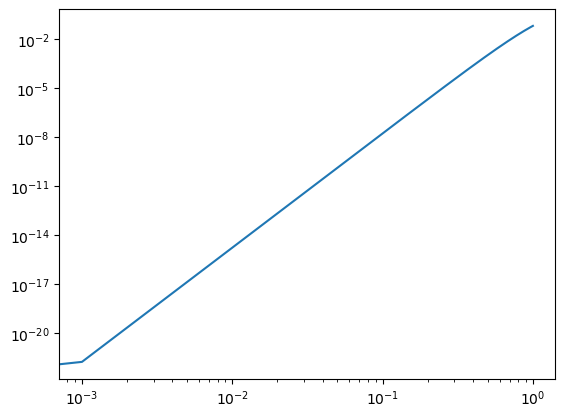

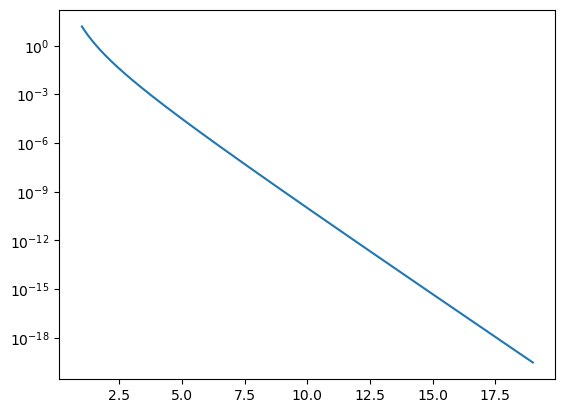

In [3]:
k=2.7
g=1.2
def f1(u):
  val = (sp.jv(3,k*u)**2)*u
  return val
def f2(u):
  val = (sp.kv(3,g*u)**2)*u
  return val
x= np.linspace(0,1,1000)
y = f1(x)
plt.loglog(x,y)
plt.show()
x= np.linspace(1,19,1000)
y = f2(x)
plt.semilogy(x,y)
plt.show()

In [4]:
I1 = integrate.quad(f1,0,1,full_output =1,epsabs = 1e-12,epsrel=1e-12)
I2 = integrate.quad(f2,1,np.inf,full_output = 1,epsabs = 1e-12,epsrel=1e-12)


In [6]:
I2

(3.0924507786178372,
 8.110042512323356e-13,
 {'neval': 105,
  'last': 4,
  'iord': array([        1,         2,         3,         4,       140,       445,
               140,       320,       140,       195,       210,        70,
               280,        70,       350,        70,       420,       195,
               420,       320,       420,       445,       350,       570,
               280,       640,       389,       640,       504,       476,
               504,       320,       504,       164,       389,         0,
               280,         0,       171,         0,        56,       164,
                56,       320,        56,       476,       171,       640,
         973145089,  11166562], dtype=int32),
  'alist': array([0.00000000e+00, 5.00000000e-01, 2.50000000e-01, 1.25000000e-01,
         1.46452325e-18, 1.40032805e-18, 1.33894976e-18, 1.28026462e-18,
         1.22415434e-18, 1.17050581e-18, 1.11921091e-18, 1.07016627e-18,
         1.02327305e-18, 9.78436787e-19, 9.3

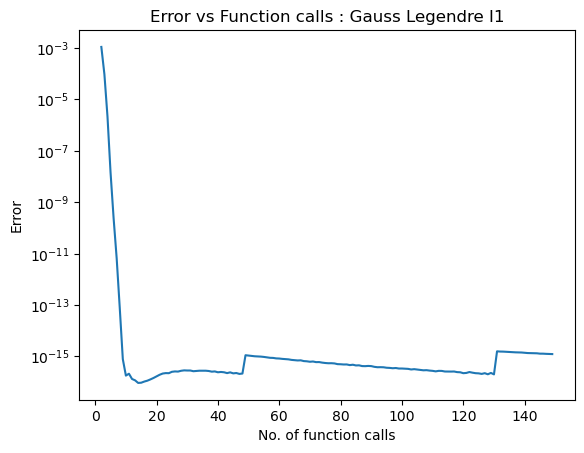

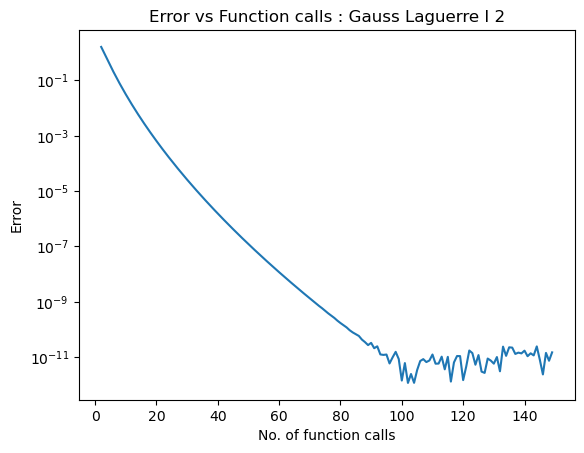

In [101]:
import matplotlib.pyplot as plt

order = range(2,150)
gau_error_1 = []
gauleg_val = []

for i in order:
    n=i
    alf = 0
    x,w = gs.gauleg(0,1,n)
    func = f1(x)
    i = np.dot(func,w)
    err = abs(i-I1[0])
    gauleg_val.append(i)
    gau_error_1.append(err)

plt.semilogy(order,gau_error_1)
plt.xlabel("No. of function calls")
plt.ylabel("Error")
plt.title("Error vs Function calls : Gauss Legendre I1")
plt.show()
    

    

order = range(2,150)
gau_error_2 = []
gauleg_val = []

for i in order:
    n=i
    alf = 0
    x,w = gs.gaulag(n,alf)
    func = f2(x+1)*x**(-alf)*np.exp(x)
    i = sum(func*w)
    err = abs(i-I2[0])
    gauleg_val.append(i)
    gau_error_2.append(err)
plt.semilogy(order,gau_error_2)

plt.xlabel("No. of function calls")
plt.ylabel("Error")
plt.title("Error vs Function calls : Gauss Laguerre I 2")
plt.show()
    



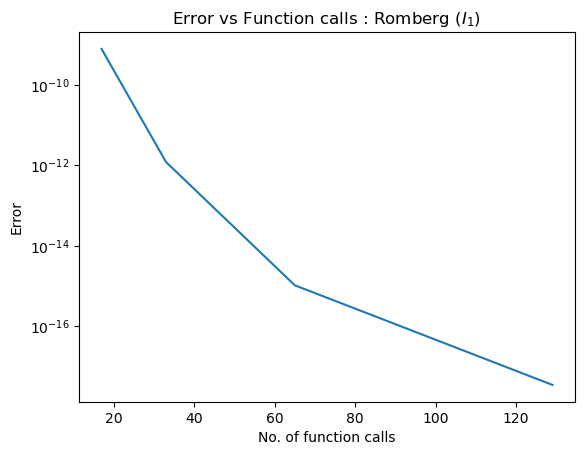

In [25]:
def romb(func, a, b, eps, k=5):
    ss, err, numcalls = romberg_module.qromb(func, a, b, eps=eps, k=k)
    return ss, err, numcalls
eps = np.logspace(-13, -3, endpoint=True)
numcalls = []
error = []

for epsilon in eps:
    y, err, calls = romb(f1, 0, 1, epsilon)
    error.append(abs(y-I1[0]))
    numcalls.append(calls)

plt.semilogy(numcalls, error)

plt.xlabel("No. of function calls")
plt.ylabel("Error")
plt.title("Error vs Function calls : Romberg I_1")
plt.show()

romberg_i1 = (numcalls.copy(), error.copy())

In [26]:
def rf2(w):
    val = f2(np.tan(w))*(1/np.cos(w))**2
    return val

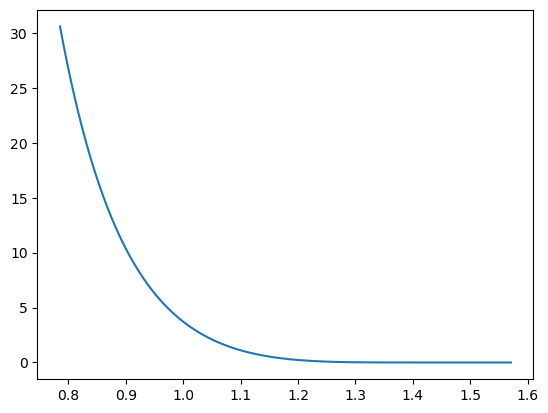

In [88]:
x= np.linspace(np.pi/4,np.pi/2,1000)
y = rf2(x)
plt.plot(x,y)

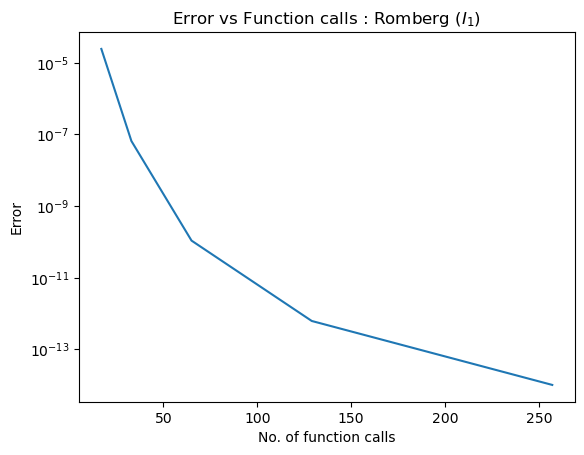

In [27]:
eps = np.logspace(-13, -3, endpoint=True)
numcalls = []
error = []

for epsilon in eps:
    y, err, calls = romb(rf2, np.pi/4, np.pi/2, epsilon)
    error.append(abs(y-I2[0]))
    numcalls.append(calls)

plt.semilogy(numcalls, error)

plt.xlabel("No. of function calls")
plt.ylabel("Error")
plt.title("Error vs Function calls : Romberg I_1")
plt.show()

romberg_i2 = (numcalls.copy(), error.copy())

Text(0.5, 1.0, 'Error vs Function calls : I1')

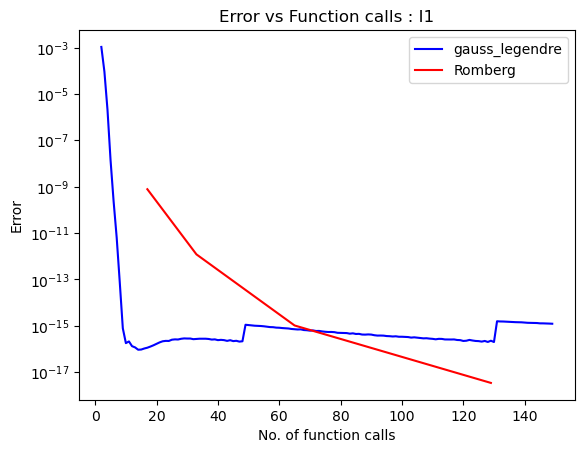

In [28]:
plt.semilogy(order,gau_error_1,"b",romberg_i1[0],romberg_i1[1],"r")
legends = ["gauss_legendre","Romberg"]
plt.legend(legends)
plt.xlabel("No. of function calls")
plt.ylabel("Error")
plt.title("Error vs Function calls : I1")

Text(0.5, 1.0, 'Error vs Function calls : I2')

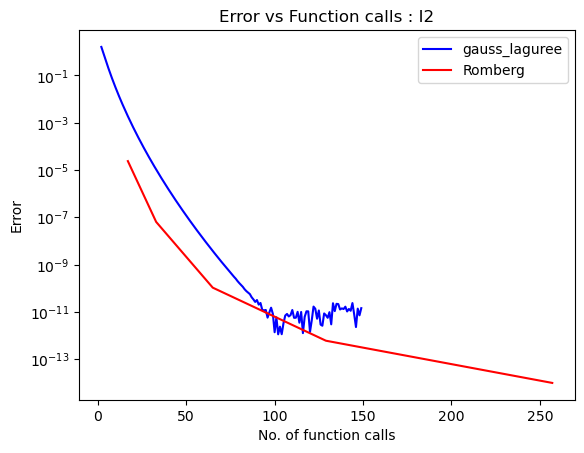

In [29]:
plt.semilogy(order,gau_error_2,"b",romberg_i2[0],romberg_i2[1],"r")
legends = ["gauss_Laguerre","Romberg"]
plt.legend(legends)
plt.xlabel("No. of function calls")
plt.ylabel("Error")
plt.title("Error vs Function calls : I2")

In [67]:
def fj(u):
    val = np.exp(-(u + 2)) / sp.j1(np.sqrt(-((u + 2)**2) + 4 * (u + 2) - 3))
    return val

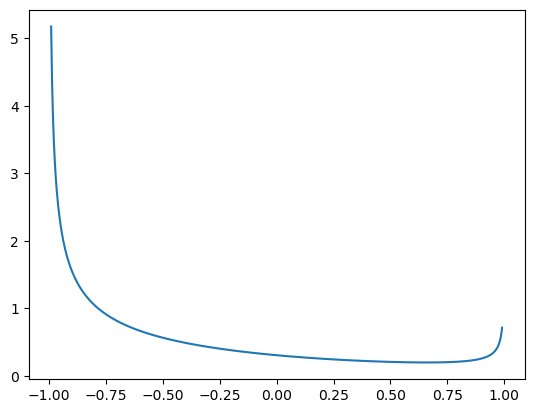

In [68]:
u = np.linspace(-0.99,0.99,1000)
plt.plot(u,fj(u))

In [108]:
def gcfj(u):
    val= fj(u)*np.sqrt(1-u**2)
    return val
N=20
def gc(N):
    j = np.array(range(1,N+1))
    xj = np.cos(np.pi*(j-0.5)/N)
    wj = np.ones(N)*np.pi/N
    return [xj,wj]
x,w = gc(N)
func = gcfj(x)
I = np.dot(w,func)
I

1.1404899385527634

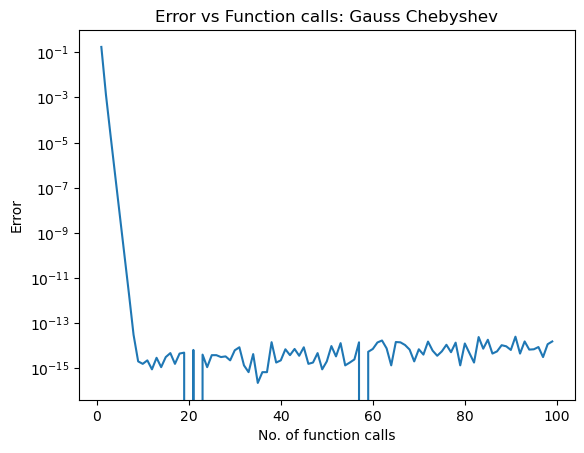

In [109]:
gau_che_calls = []
gau_che_err = []
gau_che_val = []
for i in range(1,100):
    x,w = gc(i)
    func = gcfj(x)
    Ig = np.dot(w,func)
    err = abs(Ig-I)
    gau_che_calls.append(i)
    gau_che_err.append(err)
    gau_che_val.append(Ig)


plt.semilogy(gau_che_calls, gau_che_err)

plt.xlabel("No. of function calls")
plt.ylabel("Error")
plt.title("Error vs Function calls: Gauss Chebyshev")
plt.show()
    
